# Step 6: Documentation and Final Visualizations

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')
OUTPUT_PATH = BASE_PATH / 'outputs' / 'tables'
FIGURES_PATH = BASE_PATH / 'outputs' / 'figures'
ANOMALY_PATH = BASE_PATH / 'outputs' / 'anomaly'
MODELS_PATH = BASE_PATH / 'outputs' / 'models'
COMBINED_PATH = BASE_PATH / 'data' / 'processed' / 'combined'

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

In [2]:
# Load all key results
model_results = pd.read_csv(OUTPUT_PATH / 'model_comparison_results.csv')
loso_results = pd.read_csv(OUTPUT_PATH / 'loso_results.csv')
feature_importance = pd.read_csv(OUTPUT_PATH / 'feature_importance_scores.csv')
anomaly_levels = pd.read_csv(ANOMALY_PATH / 'anomaly_level_distribution.csv')
label_dist = pd.read_csv(OUTPUT_PATH / 'label_distribution.csv')
combined_df = pd.read_csv(COMBINED_PATH / 'combined_dataset_filled.csv')

print("Data loaded successfully")

Data loaded successfully


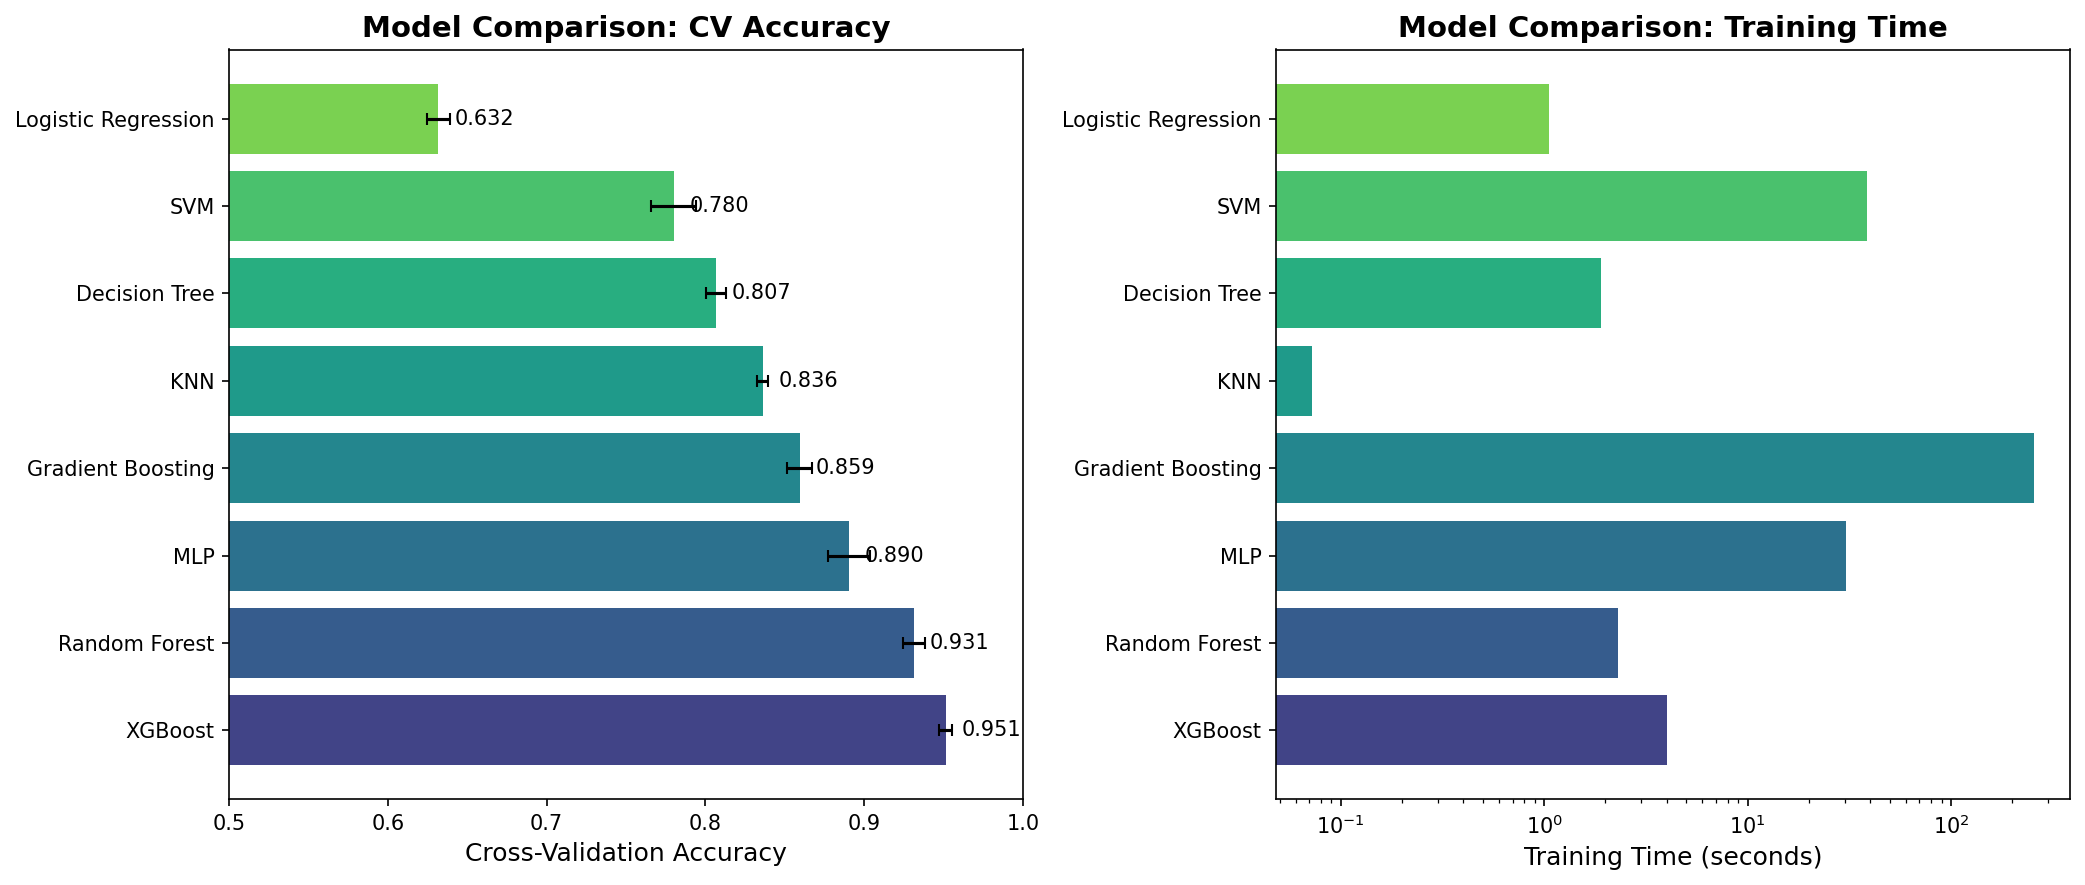

In [3]:
# 6.2 Model Comparison Visualization (High Quality)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# CV Accuracy comparison
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(model_results)))
bars = axes[0].barh(model_results['model'], model_results['cv_accuracy_mean'], 
                    xerr=model_results['cv_accuracy_std'], color=colors, capsize=3)
axes[0].set_xlabel('Cross-Validation Accuracy', fontsize=12)
axes[0].set_title('Model Comparison: CV Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlim(0.5, 1.0)
for i, v in enumerate(model_results['cv_accuracy_mean']):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

# Training time comparison
axes[1].barh(model_results['model'], model_results['training_time'], color=colors)
axes[1].set_xlabel('Training Time (seconds)', fontsize=12)
axes[1].set_title('Model Comparison: Training Time', fontsize=14, fontweight='bold')
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'model_comparison_final.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_PATH / 'model_comparison_final.pdf', bbox_inches='tight')
plt.show()

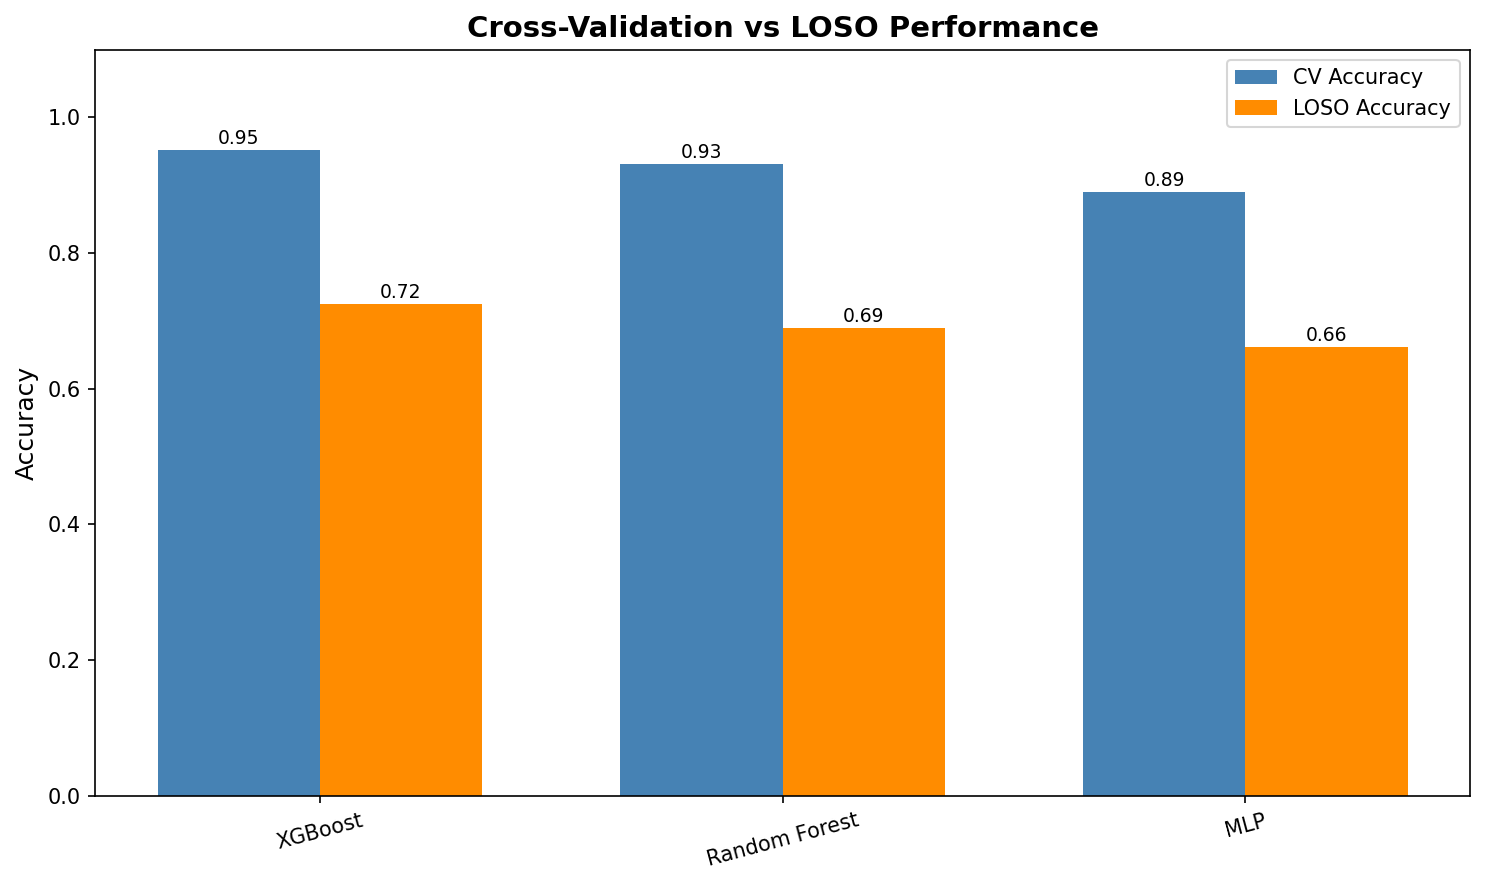

In [4]:
# LOSO Performance Summary
loso_summary = loso_results.groupby('model').agg({
    'accuracy': ['mean', 'std'],
    'f1': ['mean', 'std']
}).round(4)

fig, ax = plt.subplots(figsize=(10, 6))
models = loso_results['model'].unique()
x = np.arange(len(models))
width = 0.35

cv_means = model_results[model_results['model'].isin(models)].set_index('model').loc[models, 'cv_accuracy_mean']
loso_means = loso_results.groupby('model')['accuracy'].mean().loc[models]

bars1 = ax.bar(x - width/2, cv_means, width, label='CV Accuracy', color='steelblue')
bars2 = ax.bar(x + width/2, loso_means, width, label='LOSO Accuracy', color='darkorange')

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Cross-Validation vs LOSO Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()
ax.set_ylim(0, 1.1)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'cv_vs_loso_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

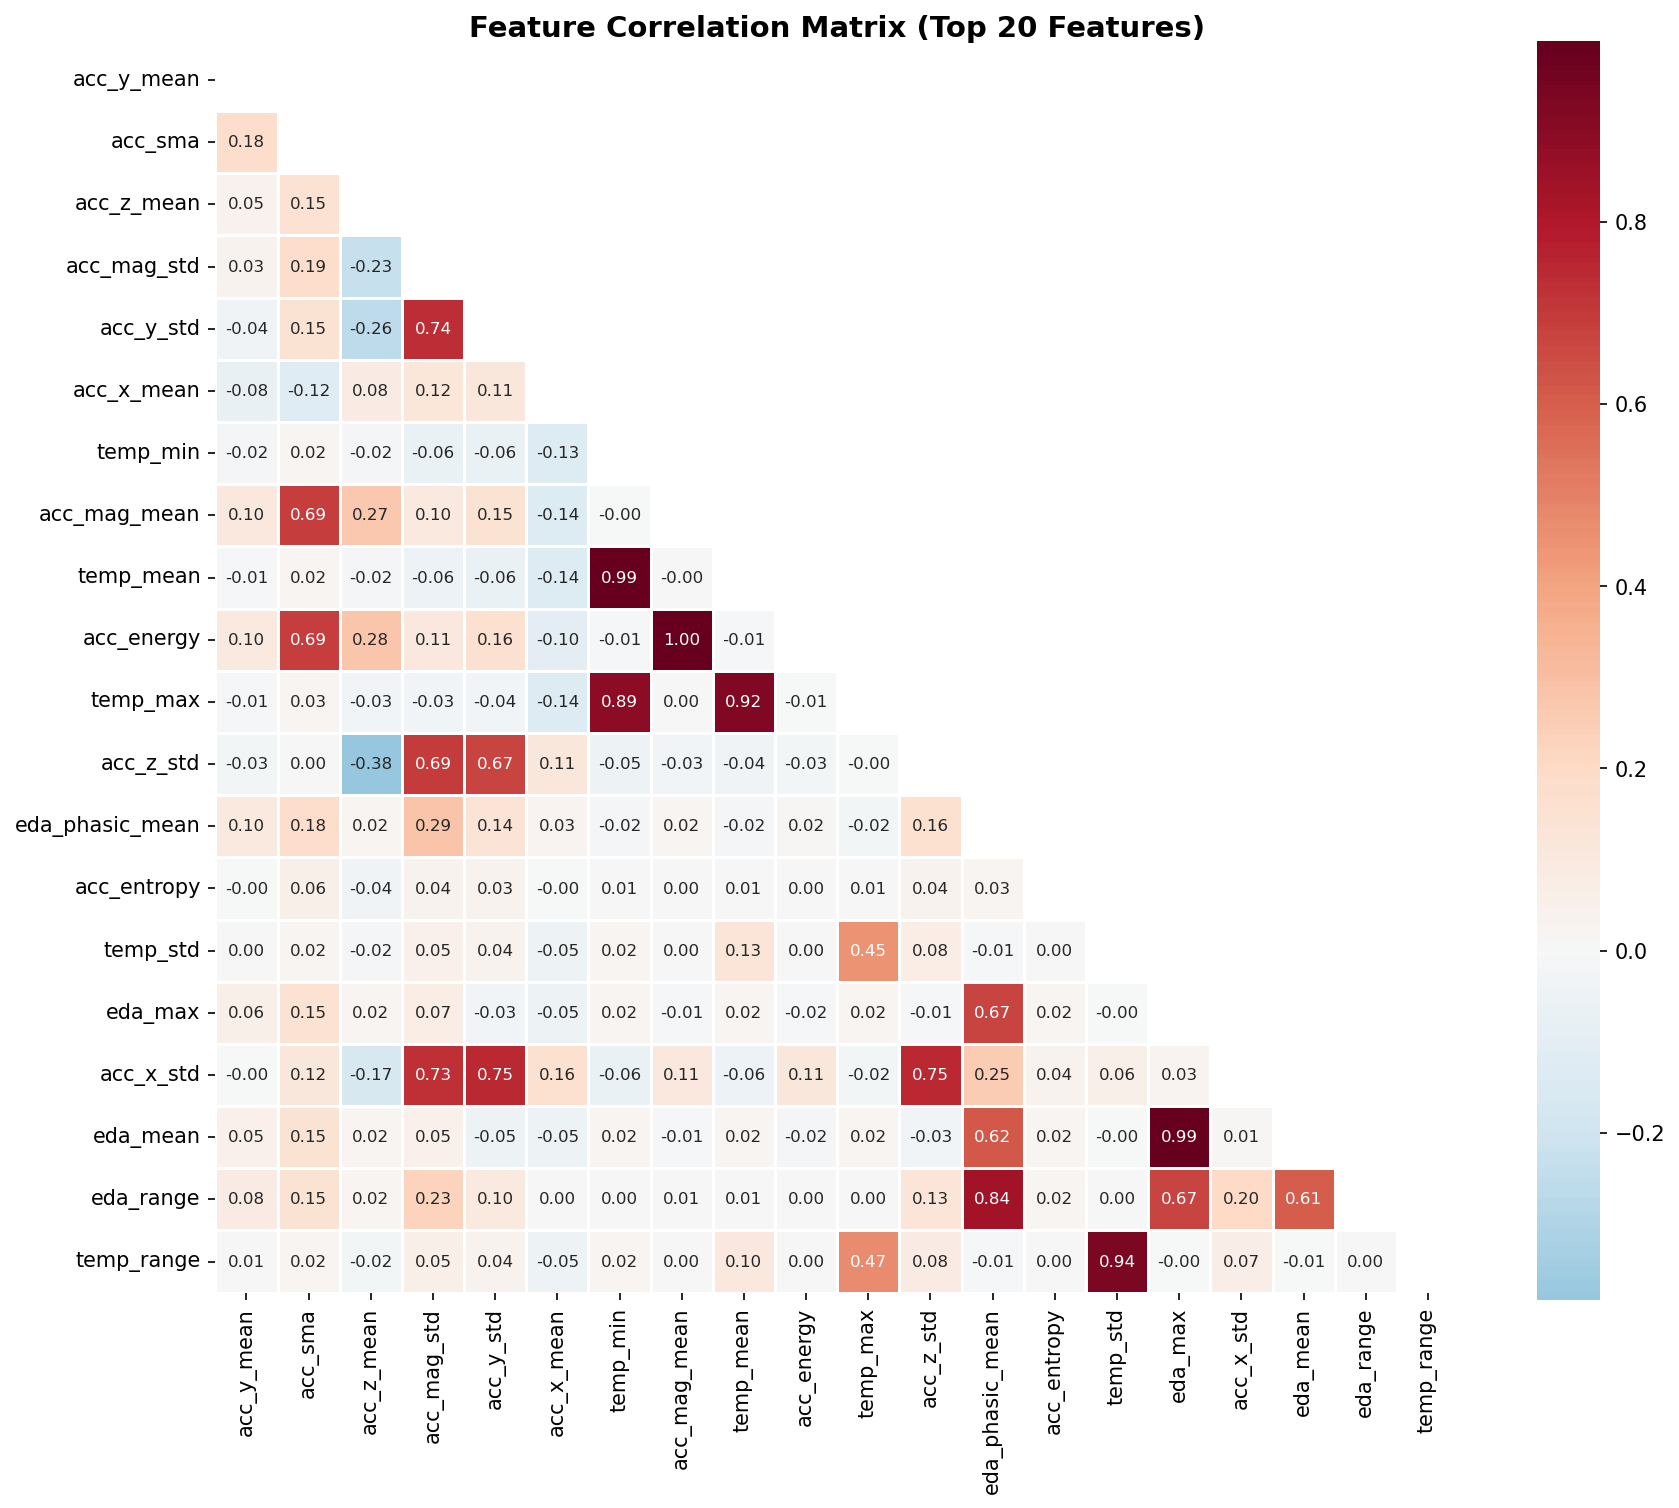

In [5]:
# Feature Correlation Heatmap
metadata_cols = ['subject_id', 'dataset', 'window_id', 'timestamp_start', 'timestamp_end', 'label']
feature_cols = [c for c in combined_df.columns if c not in metadata_cols]

# Select subset of important features for visualization
top_features = feature_importance.head(20)['feature'].tolist()
available_top = [f for f in top_features if f in feature_cols]

corr_matrix = combined_df[available_top].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, square=True, linewidths=0.5, annot_kws={'size': 8})
ax.set_title('Feature Correlation Matrix (Top 20 Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

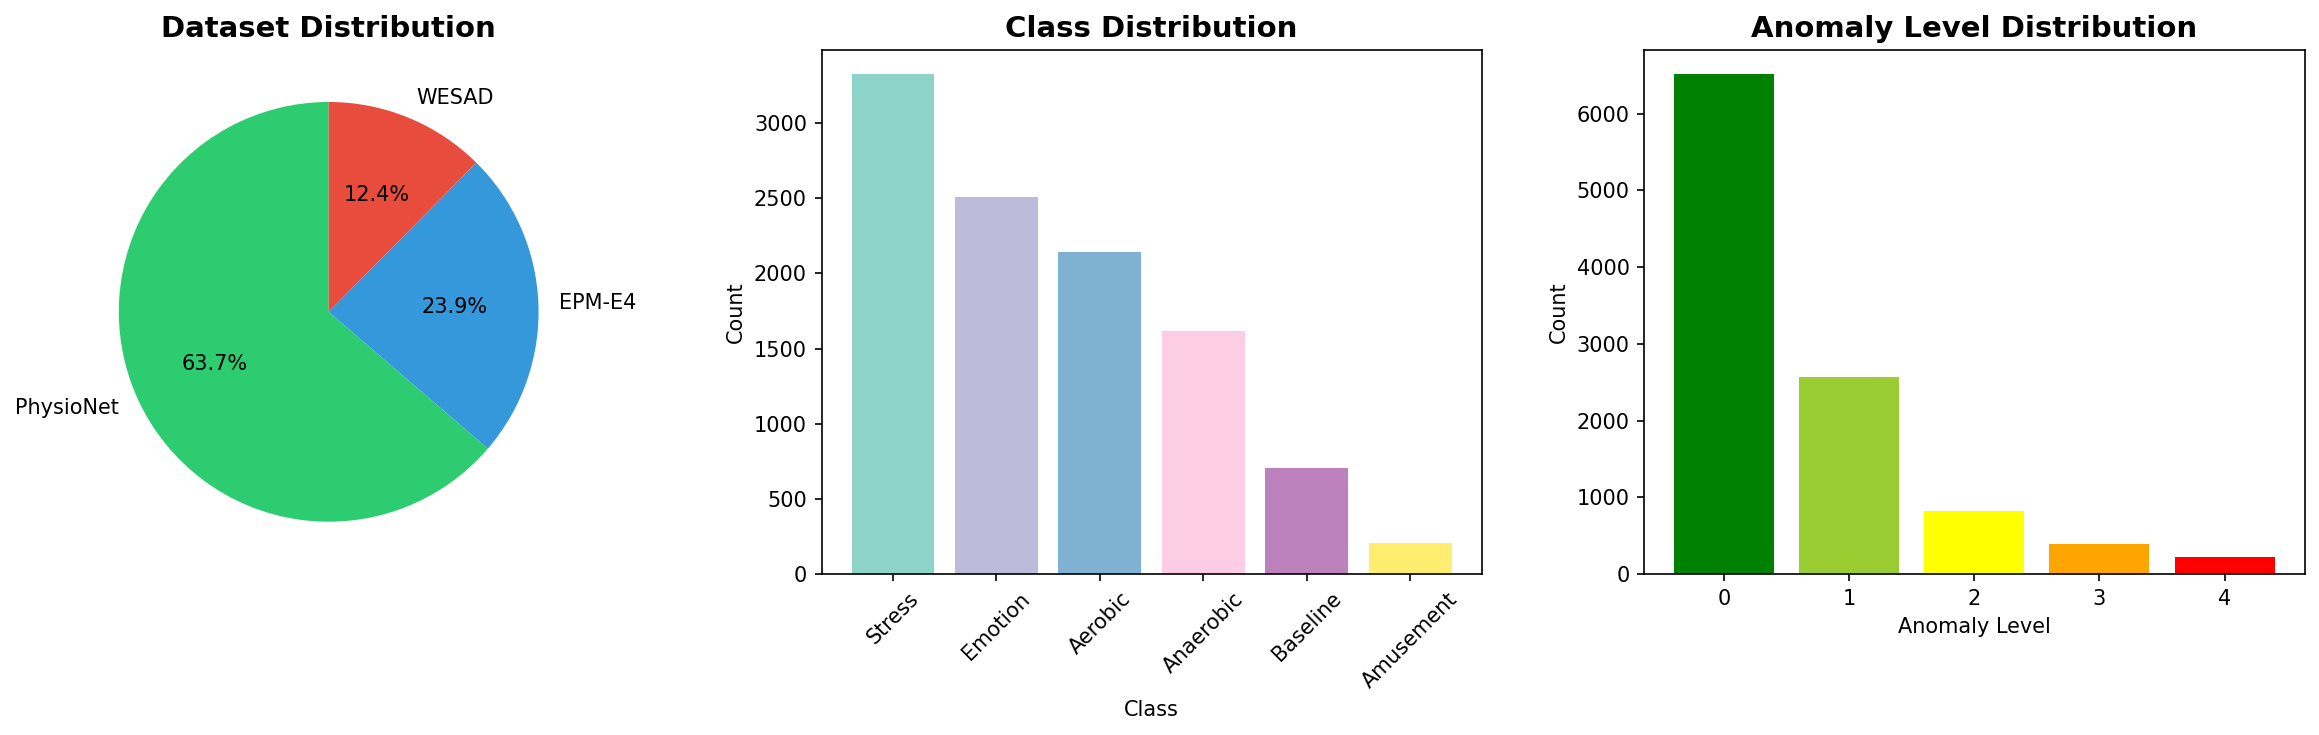

In [6]:
# Dataset and Class Distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Dataset distribution
dataset_counts = combined_df['dataset'].value_counts()
colors_ds = ['#2ecc71', '#3498db', '#e74c3c']
axes[0].pie(dataset_counts, labels=dataset_counts.index, autopct='%1.1f%%', 
            colors=colors_ds, startangle=90)
axes[0].set_title('Dataset Distribution', fontsize=14, fontweight='bold')

# Class distribution
class_counts = combined_df['label'].value_counts()
colors_cls = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
axes[1].bar(class_counts.index, class_counts.values, color=colors_cls)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# Anomaly level distribution
colors_anom = ['green', 'yellowgreen', 'yellow', 'orange', 'red']
axes[2].bar(anomaly_levels['level'], anomaly_levels['count'], color=colors_anom)
axes[2].set_xlabel('Anomaly Level')
axes[2].set_ylabel('Count')
axes[2].set_title('Anomaly Level Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'data_distribution_summary.png', dpi=300, bbox_inches='tight')
plt.show()

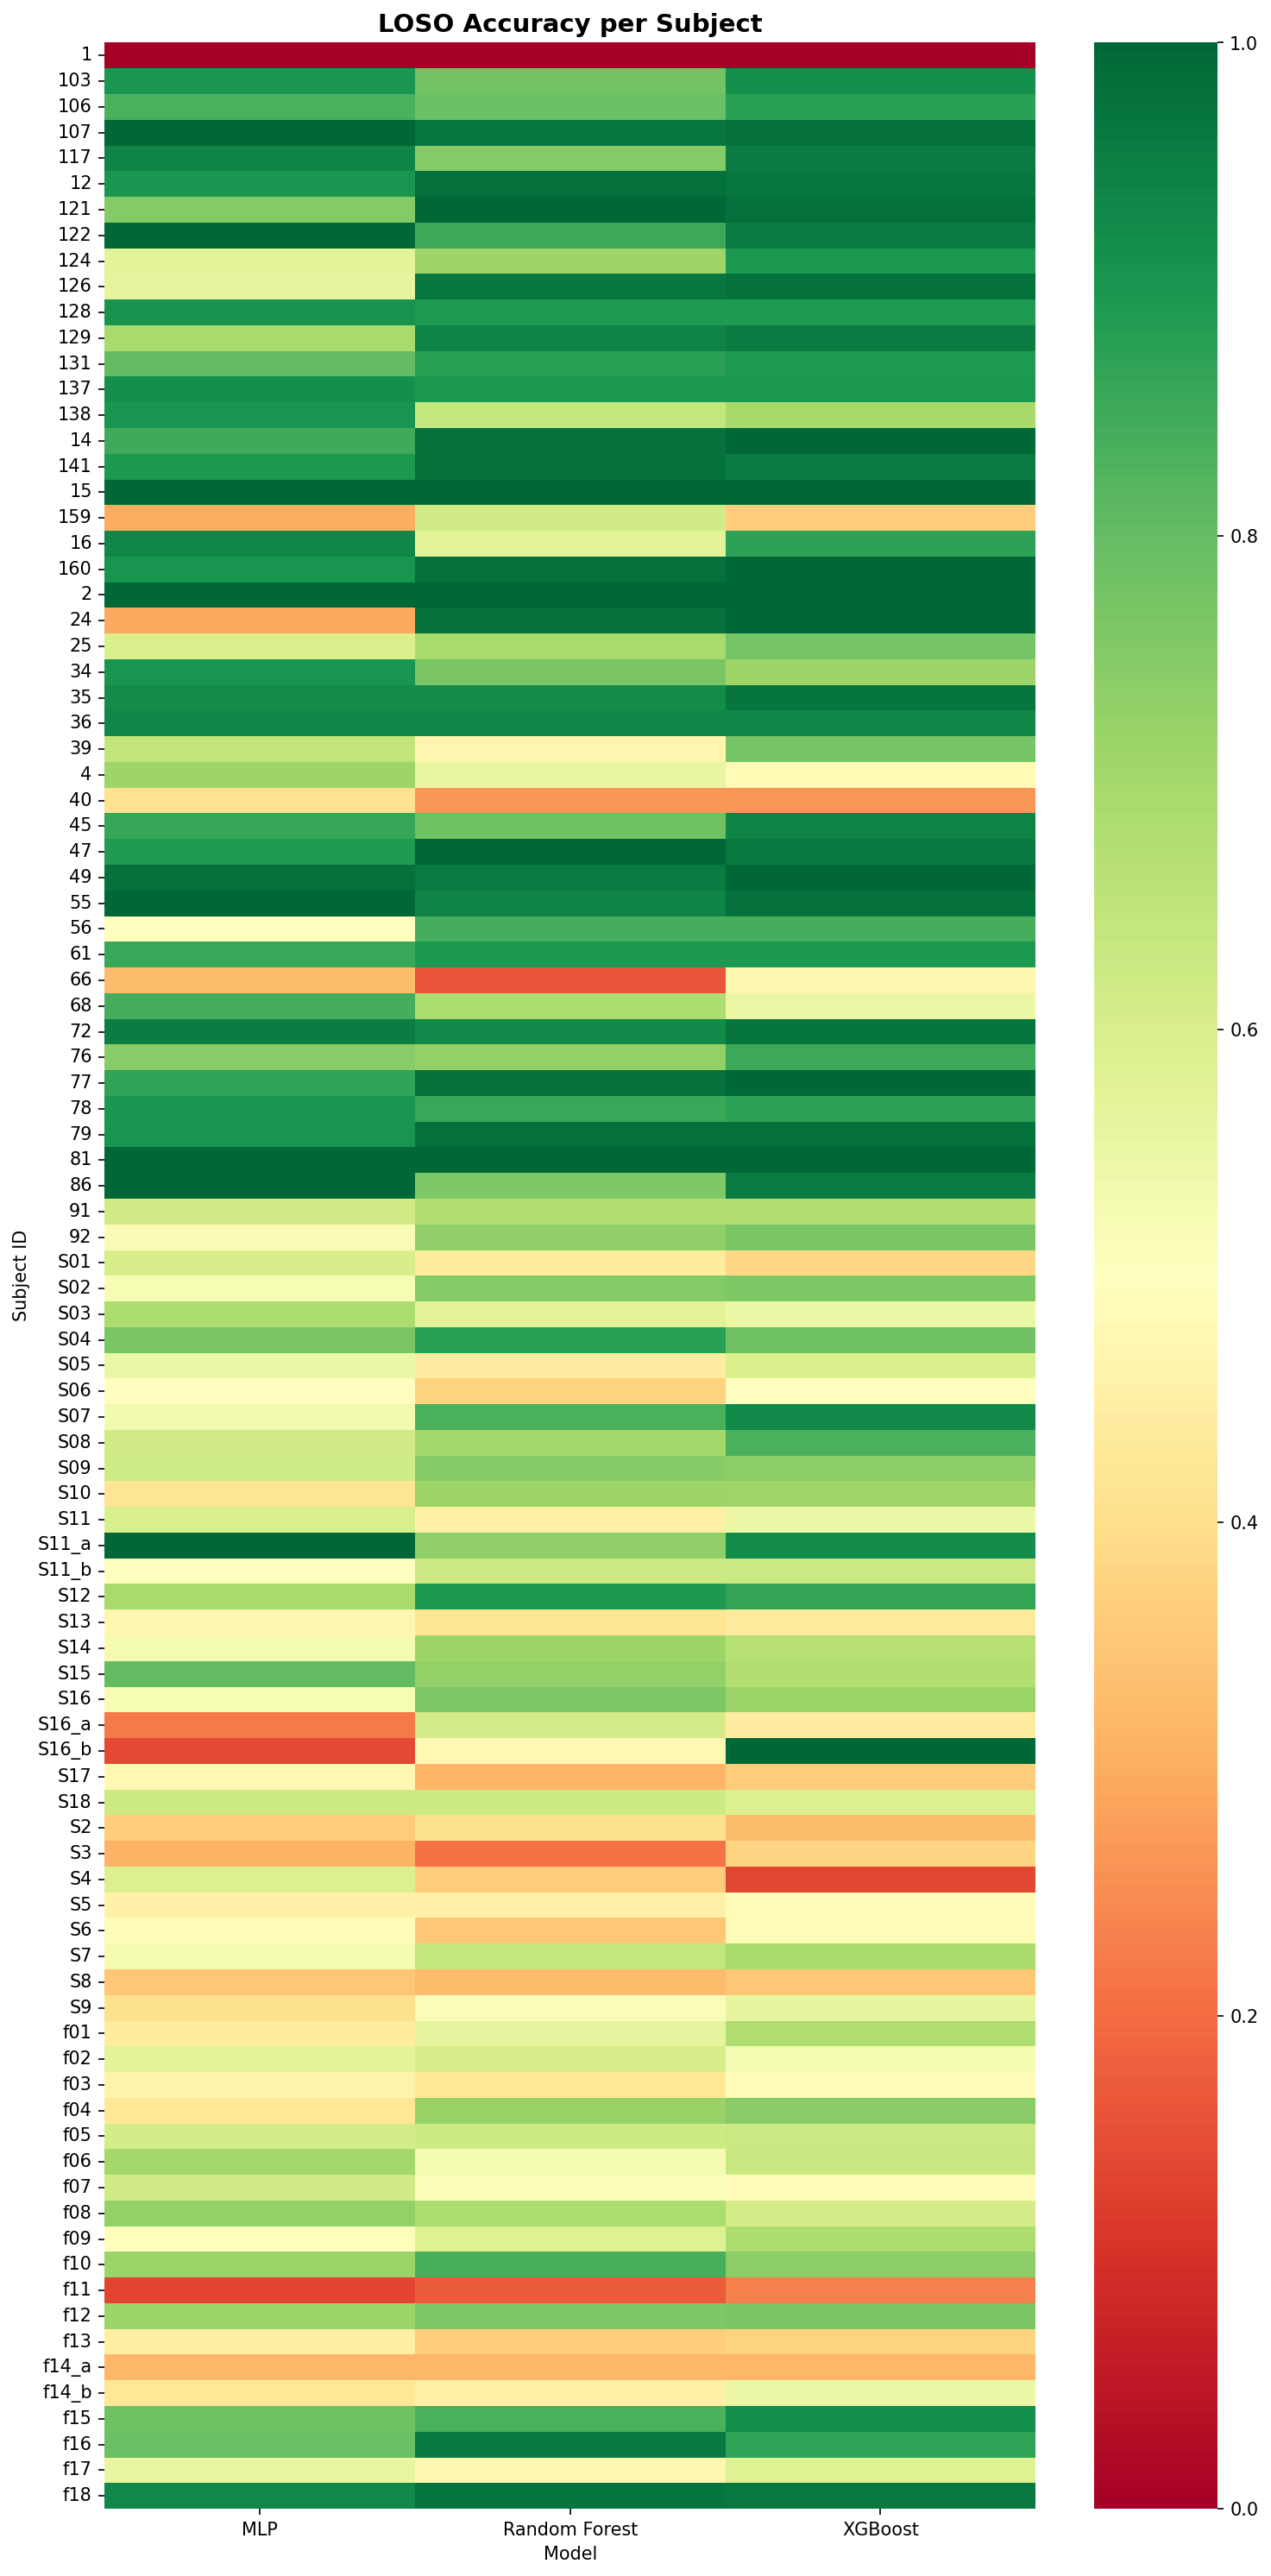

In [7]:
# Per-subject LOSO accuracy heatmap
loso_pivot = loso_results.pivot(index='subject_id', columns='model', values='accuracy')

fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(loso_pivot, annot=False, cmap='RdYlGn', vmin=0, vmax=1, ax=ax)
ax.set_title('LOSO Accuracy per Subject', fontsize=14, fontweight='bold')
ax.set_xlabel('Model')
ax.set_ylabel('Subject ID')
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'loso_subject_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Generate Summary Statistics Table
summary_stats = {
    'Metric': [
        'Total Windows',
        'Total Subjects',
        'Total Features',
        'Total Classes',
        'Best CV Accuracy',
        'Best CV Model',
        'Best LOSO Accuracy',
        'Best LOSO Model',
        'Consensus Outliers',
        'Level 3-4 Anomalies'
    ],
    'Value': [
        len(combined_df),
        combined_df['subject_id'].nunique(),
        len(feature_cols),
        combined_df['label'].nunique(),
        f"{model_results['cv_accuracy_mean'].max():.4f}",
        model_results.loc[model_results['cv_accuracy_mean'].idxmax(), 'model'],
        f"{loso_results.groupby('model')['accuracy'].mean().max():.4f}",
        loso_results.groupby('model')['accuracy'].mean().idxmax(),
        anomaly_levels[anomaly_levels['level'] >= 2]['count'].sum(),
        anomaly_levels[anomaly_levels['level'] >= 3]['count'].sum()
    ]
}

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv(OUTPUT_PATH / 'project_summary_stats.csv', index=False)
print("\nProject Summary Statistics:")
print(summary_df.to_string(index=False))


Project Summary Statistics:
             Metric   Value
      Total Windows   10511
     Total Subjects      96
     Total Features      39
      Total Classes       6
   Best CV Accuracy  0.9513
      Best CV Model XGBoost
 Best LOSO Accuracy  0.7242
    Best LOSO Model XGBoost
 Consensus Outliers    1436
Level 3-4 Anomalies     618


In [9]:
# Generate LaTeX tables for thesis
# Model comparison table
latex_model = model_results[['model', 'cv_accuracy_mean', 'cv_accuracy_std', 'f1_weighted', 'training_time']].copy()
latex_model.columns = ['Model', 'CV Acc', 'Std', 'F1', 'Time (s)']
latex_model['CV Acc'] = latex_model['CV Acc'].apply(lambda x: f'{x:.4f}')
latex_model['Std'] = latex_model['Std'].apply(lambda x: f'{x:.4f}')
latex_model['F1'] = latex_model['F1'].apply(lambda x: f'{x:.4f}')
latex_model['Time (s)'] = latex_model['Time (s)'].apply(lambda x: f'{x:.2f}')

latex_table = latex_model.to_latex(index=False, caption='Model Comparison Results', label='tab:model_comparison')
with open(OUTPUT_PATH / 'model_comparison_latex.tex', 'w') as f:
    f.write(latex_table)
print("LaTeX table saved")
print(latex_model.to_string(index=False))

LaTeX table saved
              Model CV Acc    Std     F1 Time (s)
            XGBoost 0.9513 0.0040 1.0000     4.03
      Random Forest 0.9313 0.0070 1.0000     2.30
                MLP 0.8902 0.0133 1.0000    30.35
  Gradient Boosting 0.8593 0.0081 0.9213   255.72
                KNN 0.8360 0.0037 0.9144     0.07
      Decision Tree 0.8066 0.0062 1.0000     1.90
                SVM 0.7801 0.0142 0.8127    38.59
Logistic Regression 0.6318 0.0074 0.6294     1.05


In [10]:
# LOSO summary table
loso_summary_table = loso_results.groupby('model').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'f1': 'mean'
}).round(4)
loso_summary_table.columns = ['Mean Acc', 'Std', 'Min', 'Max', 'Mean F1']
loso_summary_table = loso_summary_table.reset_index()

latex_loso = loso_summary_table.to_latex(index=False, caption='LOSO Validation Results', label='tab:loso_results')
with open(OUTPUT_PATH / 'loso_results_latex.tex', 'w') as f:
    f.write(latex_loso)
print("\nLOSO Summary:")
print(loso_summary_table.to_string(index=False))


LOSO Summary:
        model  Mean Acc    Std  Min  Max  Mean F1
          MLP    0.6615 0.2366  0.0  1.0   0.7172
Random Forest    0.6890 0.2367  0.0  1.0   0.7333
      XGBoost    0.7242 0.2385  0.0  1.0   0.7595


In [11]:
# List all output files
print("\n" + "="*60)
print("STEP 6 COMPLETE: Documentation")
print("="*60)

print("\nFigures Generated:")
for f in sorted(FIGURES_PATH.glob('*.png')):
    print(f"  - {f.name}")

print("\nTables Generated:")
for f in sorted(OUTPUT_PATH.glob('*.csv')):
    print(f"  - {f.name}")

print("\nLaTeX Tables:")
for f in sorted(OUTPUT_PATH.glob('*.tex')):
    print(f"  - {f.name}")

print("\nModels Saved:")
for f in sorted(MODELS_PATH.glob('*.pkl')):
    print(f"  - {f.name}")

print("\nAnomaly Outputs:")
for f in sorted(ANOMALY_PATH.glob('*.csv')):
    print(f"  - {f.name}")

print("="*60)


STEP 6 COMPLETE: Documentation

Figures Generated:
  - anomaly_distribution.png
  - anomaly_signal_distributions.png
  - cv_vs_loso_comparison.png
  - data_distribution_summary.png
  - feature_correlation_heatmap.png
  - feature_importance_comparison.png
  - feature_importance_rf.png
  - label_distribution.png
  - loso_accuracy_distribution.png
  - loso_subject_heatmap.png
  - model_comparison_final.png

Tables Generated:
  - all_subjects_inventory.csv
  - dataset_structure_summary.csv
  - epm_subjects.csv
  - excluded_subjects.csv
  - feature_importance_scores.csv
  - feature_mapping_table.csv
  - imputation_accuracy_report.csv
  - label_distribution.csv
  - loso_results.csv
  - missing_data_log.csv
  - model_comparison_results.csv
  - normal_ranges_per_class.csv
  - outlier_detection_comparison.csv
  - physionet_constraints.csv
  - physionet_subjects.csv
  - project_summary_stats.csv
  - rf_feature_selection_metrics.csv
  - sampling_rates.csv
  - signal_quality_report.csv
  - subjec